In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import os
import sys

%matplotlib inline

In [4]:
CURR_PATH = os.path.dirname(os.path.abspath('__file__'))
ROOT =  os.path.join(CURR_PATH)
FIG =  os.path.join(CURR_PATH,'fig')
sys.path.append(os.path.join(ROOT,'modules'))

import style as style
style.set_style()

import features as feat

Style set


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1485 entries, 2011-10-10 22:00:00 to 2017-10-09 22:00:00
Data columns (total 5 columns):
open      1485 non-null float64
high      1485 non-null float64
low       1485 non-null float64
close     1485 non-null float64
volume    1485 non-null float64
dtypes: float64(5)
memory usage: 69.6 KB


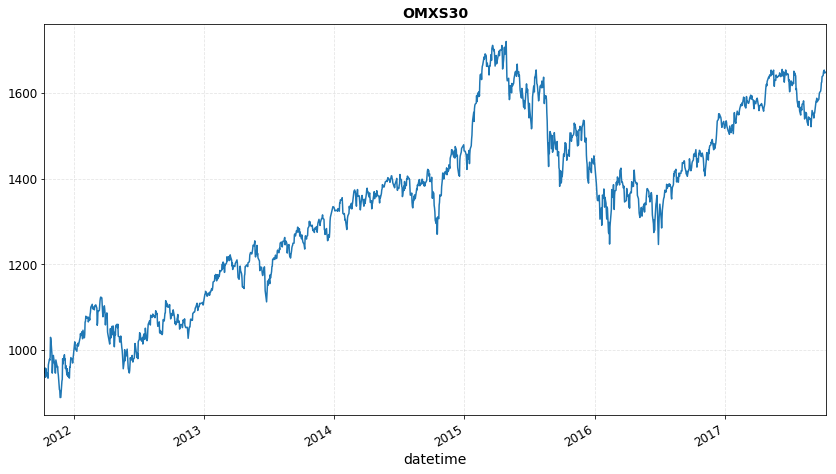

In [5]:
df = pd.read_pickle(os.path.join('data','quote=OMXS30&start=2011-10-10&end=2017-10-09&interval=1440min.pkl'))
df = df.groupby(['datetime']).sum()
df.info()
df.head()
df['close'].plot(grid=True, title = 'OMXS30')

In [18]:
# Add features
df = df.pipe(feat.add_input_variables,days=10)
df = df.pipe(feat.add_output_variables,days=10)
df = df.join(df['y_open_close_days_0'].pipe(feat.to_bin))
df = df.join(df['x_open_open_day_1'].pipe(feat.to_bin))
df = df.join(df['x_open_open_day_1_up'].pipe(feat.up_down_streak))

In [19]:
# Add other measures
df['x_weekday'] = df.index.weekday
df['x_month'] = df.index.month
df['x_year'] = df.index.year
df['x_quarter'] = df.index.quarter
df['x_dayofmonth'] = df.index.day
df[['x_weekday','x_dayofmonth']].head()

,x_weekday,x_dayofmonth
datetime,,
2011-10-10 22:00:00,0,10
2011-10-11 22:00:00,1,11
2011-10-12 22:00:00,2,12
2011-10-13 22:00:00,3,13
2011-10-14 22:00:00,4,14


In [22]:
agg = {'count','mean'}
df[['y_open_close_days_0','x_open_open_day_1_up_streak']].replace([np.inf,-np.inf],np.nan).dropna().groupby('x_open_open_day_1_up_streak').agg(agg)

y_open_close_days_0      
                                           mean count
x_open_open_day_1_up_streak                          
-7.0                                   0.229347     1
-6.0                                   0.915621     7
-5.0                                   0.003921    20
-4.0                                  -0.195784    33
-3.0                                   0.179202    73
-2.0                                   0.048919   167
-1.0                                   0.019236   382
 0.0                                   2.516692     1
 1.0                                  -0.037663   382
 2.0                                  -0.038574   197
 3.0                                   0.108786   103
 4.0                                  -0.057772    59
 5.0                                   0.170693    28
 6.0                                   0.030511    17
 7.0                                   0.089902     6
 8.0                                  -0.249289     3
 9.0                                   0.790121     1
 10.0                                  0.172983     1
 11.0                                  0.519639     1
 12.0                                  0.115953     1
 13.0                                  0.124914     1
 14.0                                 -0.415795     1

9


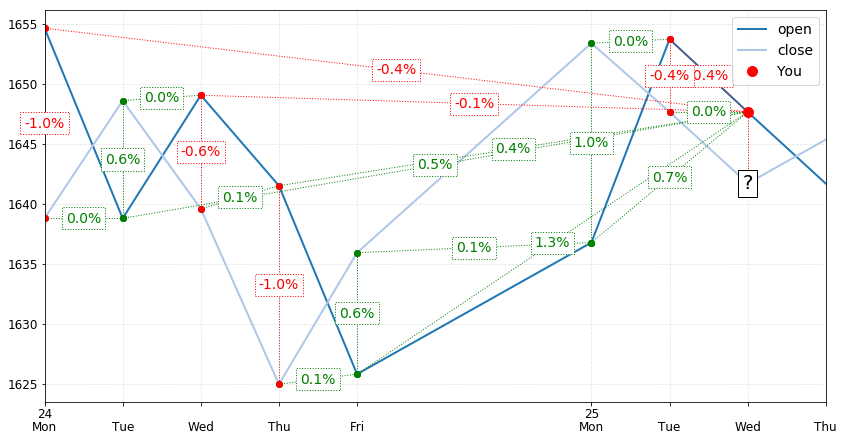

In [23]:
import plot as hp

days = 15
start_date = pd.to_datetime('2017-06-10')
df_sel = df[(df.index < start_date+pd.DateOffset(days=days)) &
                       (df.index >= start_date)][['open','close','high','low']]

days = df_sel.shape[0]
print(days)
f, ax = plt.subplots(1,1)
df_sel[['open','close']].plot(lw=2,ax=ax)
d_day = 7
HIST = True
PRED = True
if HIST:
    for i in np.arange(0,d_day):
        x1 = df_sel.index[i]; x2 = df_sel.index[i+1]
        df_sel.pipe(hp.add_measurement,x=[x1,x2],m=['close','open'],ax=ax,color='y',text=True)
        x1 = df_sel.index[i]; x2 = df_sel.index[d_day]
        df_sel.pipe(hp.add_measurement,x=[x1,x2],m=['open','open'],ax=ax,color='y',text=True)
        x1 = df_sel.index[i]; x2 = df_sel.index[i]
        df_sel.pipe(hp.add_measurement,x=[x1,x2],m=['open','close'],ax=ax,color='y',text=True)
if PRED:
    for i in np.arange(d_day,d_day+1):
        x1 = df_sel.index[d_day]; x2 = df_sel.index[i]
        df_sel.pipe(hp.add_measurement,x=[x1,x2],m=['open','close'],ax=ax,color='orange')

# YOU
df_sel.iloc[[d_day]]['open'].rename('You').plot(marker='o', linestyle='none', color='r',ax=ax, legend=True ,
                                                ms=10,alpha=1,lw=1)
# QUESTIONMARK
offset = 0
ax.text(x=df_sel.index[d_day+offset], y=df_sel.loc[df_sel.index[d_day+offset]]['close'], s='?',size=20,ha="center",
        va="center", bbox=dict(facecolor='white',ls='-'))

df_sel.pipe(hp.set_daily_xticks,ax)
filename  = 'all-'+str(days)+'-hist-'+str(HIST)+'-pred-'+str(PRED)+'.png'
#hp.save_fig(f, filename)

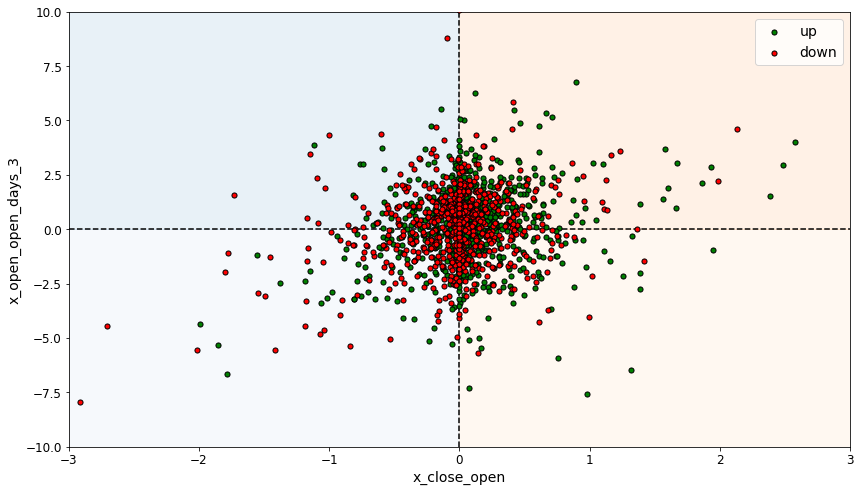

In [24]:
# Close price change dependancy
f, ax = plt.subplots(1,1)
x = 'x_close_open'
y = 'x_open_open_days_3'

    #print('Neg:',df_sel[df_sel[x]<0][y].replace(np.inf,np.nan).dropna().mean())
    #print('Pos:',df_sel[df_sel[x]>0][y].replace(np.inf,np.nan).dropna().mean())
df[df['y_open_close_days_0_up']==1].plot(ax=ax,kind='scatter',x=x,y=y,s=26,color='g',edgecolor='black',zorder=3,label='up')
df[df['y_open_close_days_0_up']==0].plot(ax=ax,kind='scatter',x=x,y=y,s=26,color='r',edgecolor='black',zorder=3,label='down')
ax.set_title('')

#plt.axvline(-1,ls='--',color='r')
x_width = 3
y_width = 10

hp.color_quantiles(ax,x_width,y_width)


#ax.text(-7,7,'Open [-]\nClose [+]\nOverreaction during Pre-Market?')
#ax.text(-7,-7,'Open [-]\nClose [-]\nDecline continues during the day?')
#ax.text(3,7,'Open [+]\nClose [+]\nIncrease continues during the day')
#ax.text(3,-7,'Open [+]\nClose [-]\nGood morning, bad day')

hp.save_fig(f, 'testdsf.png')